In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import flatten_dict
import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as image
import torchvision
from IPython import display
from viewmaker.src.systems.image_systems.utils import heatmap_of_view_effect
import pylab as pyl
%matplotlib inline
from dabs.src.systems import viewmaker, viewmaker_original

config = OmegaConf.load('/disk2/ofirb/dabs/conf/pretrain_original_jit.yaml')
config.debug = True
config.dataset = OmegaConf.load('/disk2/ofirb/dabs/conf/dataset/lfw112.yaml')
config.model = OmegaConf.load('/disk2/ofirb/dabs/conf/model/jit_model.yaml')

config.dataset.batch_size = 10

pl.seed_everything(config.trainer.seed)

if config.algorithm == 'viewmaker':
    system = viewmaker.ViewmakerSystem(config)
elif config.algorithm == 'original_viewmaker':
    system = viewmaker_original.OriginalViewmakerSystem(config)
elif config.algorithm ==  'viewmaker_original_disc':
    system = viewmaker_original.ViewmakerOriginalSystemDisc(config)
elif config.algorithm ==  'viewmaker_ceva_disc':
    system = viewmaker_original.CevaViewmakerSystem(config)

system.setup('')
if config.trainer.resume_from_checkpoint:
    system.load_state_dict(torch.load(config.trainer.resume_from_checkpoint)['state_dict'],strict=False)

system.eval()

/disk2/ofirb/enviroments/viewmaker/lib/python3.7/site-packages/librosa/core/constantq.py:1059: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.complex,
Global seed set to 0


11907 train examples, 1323 val examples


OriginalViewmakerSystem(
  (model): JitModel(
    (embed_modules): ModuleList()
    (jit_model): RecursiveScriptModule(
      original_name=MobileFaceNet
      (conv1): RecursiveScriptModule(
        original_name=_ConstSequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=ReLU6)
      )
      (dw_conv): RecursiveScriptModule(
        original_name=DepthwiseSeparableConv
        (depthwise): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (pointwise): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (features): RecursiveScriptModule(
        original_name=_ConstSequential
        (0): RecursiveScriptModule(
          original_name=InvertedResidual
          (conv): Re

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as image
import torchvision
from IPython import display
from viewmaker.src.systems.image_systems.utils import heatmap_of_view_effect
import pylab as pl
import matplotlib as mpl

%matplotlib inline
from bokeh.plotting import figure,show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [19]:
def f(x):
    r = 10
    c = 10
    print(f"showing images : {r*c*x} - {r*c*(x+1) -1}")
    fig = plt.figure(figsize=(15,16))
    axs = fig.subplots(r,c)
    for i in range(r):
        for j in range(c):
            _,img_sample,_ = system.train_dataset[r*c*x+ i*c + j]
            axs[i,j].imshow(img_sample.permute(1,2,0))
            axs[i,j].text(0,0,f'{i*c + j + r*c*x}')
            axs[i,j].axis("off")
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.show()

In [20]:
interact(f,x=widgets.IntText(min=0, max=11900//100, step=1, value=0));

interactive(children=(IntText(value=0, description='x'), Output()), _dom_classes=('widget-interact',))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.3887]], grad_fn=<MmBackward>)


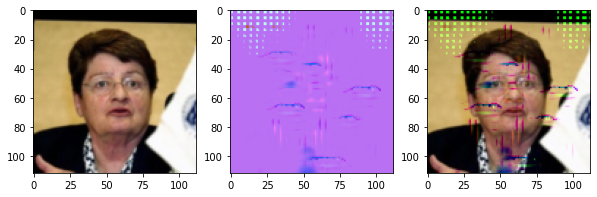

In [6]:
_,img,_ = system.train_dataset[725]
normalized_view, view = system.view(img.unsqueeze(0),True)
fig = plt.figure(figsize=(10,3))
axs = fig.subplots(1,3)
axs[0].imshow(img.permute(1,2,0))
axs[1].imshow(heatmap_of_view_effect(img,view[0].detach()).permute(1,2,0))
axs[2].imshow(view[0].detach().permute(1,2,0))

fig.show()


img_embd = system.model.encode(img.unsqueeze(0))
img_embd = img_embd / img_embd.norm()
view_embd = system.model.encode(view)
view_embd = view_embd / view_embd.norm()
print(img_embd @ view_embd.T)

In [10]:
torchvision.io.write_jpeg((view[0]*255).byte(),'is_it_real.jpeg')


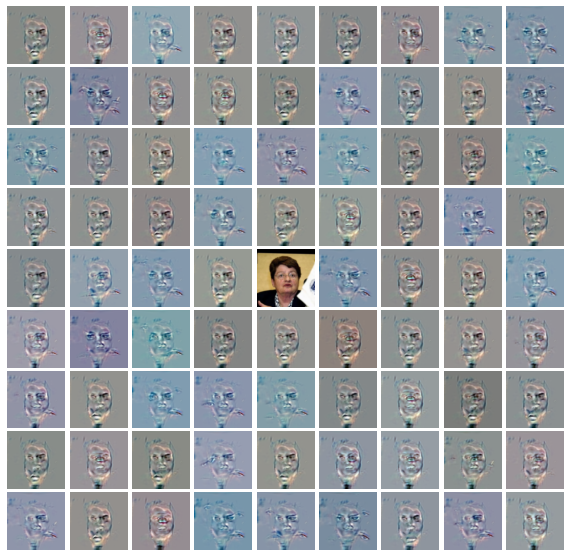

In [11]:
subject_img = img

fig = plt.figure(figsize=(10,10))
r = 9
c = 9
axs = fig.subplots(r,c)
axs[(r)//2,(c)//2].imshow(subject_img.permute(1,2,0))
axs[(r)//2,(c)//2].axis("off")
for i in range(r):
    for j in range(c):
        if i == (r)//2 and j == (c)//2:
            continue
        normalized_view, view = system.view(subject_img.unsqueeze(0),True)
        axs[i,j].imshow(heatmap_of_view_effect(subject_img,view[0].detach()).permute(1,2,0))
        axs[i,j].axis("off")
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.show()

In [12]:
subject_img = img
count = 1000
total_delta = torch.zeros_like(img[0])
for i in range(count):
    normalized_view, view = system.view(subject_img.unsqueeze(0),True)
    delta = view[0] - subject_img
    total_delta += delta.abs().mean(axis=[0])

total_delta /= count


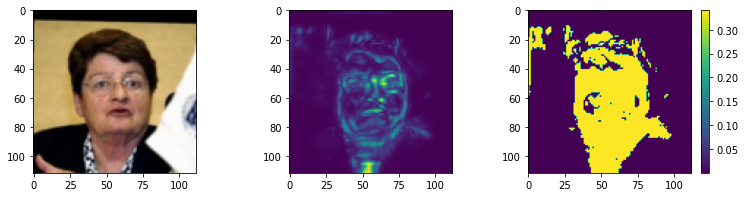

In [23]:
fig = plt.figure(figsize=(13,3))
axs = fig.subplots(1,3)
axs[0].imshow(img.permute(1,2,0))
axs[1].imshow(total_delta.detach())

relevancy_mask = total_delta < 0.02
axs[2].imshow(1-relevancy_mask.detach().float())
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=total_delta.min(), vmax=total_delta.max())
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
fig.show()

irrelevant noised : tensor([[0.9970]], grad_fn=<MmBackward>)
relevant noised : tensor([[0.7708]], grad_fn=<MmBackward>)


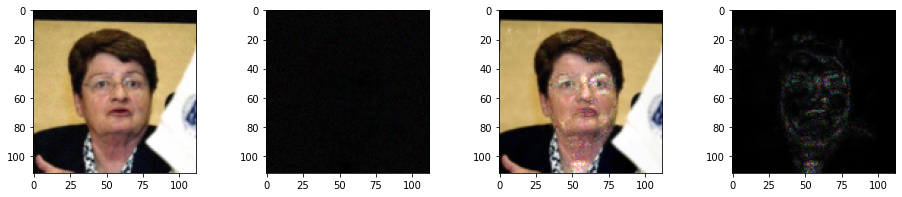

In [75]:
irrelevant_noised = img.clone()
random_noise = torch.rand_like(img)
budget = 0.025
# irrelevant_noised[relevancy_mask.expand(3,-1,-1)] += budget*random_noise[relevancy_mask.expand(3,-1,-1)] / (random_noise[relevancy_mask.expand(3,-1,-1)].abs().mean()+1e-4)
irrelevant_noise =  random_noise * (1-((total_delta-total_delta.min())/(total_delta.max()-total_delta.min())))
irrelevant_noised += budget*irrelevant_noise/(irrelevant_noise.abs().mean()+1e-4)

relevant_noised = img.clone()
# relevant_noised[(~relevancy_mask).expand(3,-1,-1)] += budget*random_noise[~relevancy_mask.expand(3,-1,-1)] / (random_noise[~relevancy_mask.expand(3,-1,-1)].abs().mean()+1e-4)
relevant_noise = random_noise* ((total_delta-total_delta.min())/(total_delta.max()-total_delta.min()))
relevant_noised += budget*relevant_noise/(relevant_noise.abs().mean()+1e-4)

fig = plt.figure(figsize=(16,3))
axs = fig.subplots(1,4)
axs[0].imshow(irrelevant_noised.permute(1,2,0).clamp(0,1).detach())
axs[1].imshow((irrelevant_noised-img).permute(1,2,0).clamp(0,1).detach())

axs[2].imshow(relevant_noised.permute(1,2,0).clamp(0,1).detach())
axs[3].imshow((relevant_noised-img).permute(1,2,0).clamp(0,1).detach())
cmap = mpl.cm.viridis
fig.show()

irrelevant_noised_embd = system.model.encode(irrelevant_noised.unsqueeze(0))
irrelevant_noised_embd = irrelevant_noised_embd / irrelevant_noised_embd.norm()
print(f'irrelevant noised : {img_embd @ irrelevant_noised_embd.T}')

relevant_noised_embd2 = system.model.encode(relevant_noised.unsqueeze(0))
relevant_noised_embd2 = relevant_noised_embd2 / relevant_noised_embd2.norm()
print(f'relevant noised : {img_embd @ relevant_noised_embd2.T}')

In [57]:
img.shape

torch.Size([3, 112, 112])

dtype('float32')

In [64]:
import matplotlib.image as plt_img
plt_img.imsave('name.png', img.permute(1,2,0).numpy())

In [73]:
red = plt_img.imread('red.png')
purple = plt_img.imread('purple.png')
red_purple = plt_img.imread('red_purple.png')

red : tensor([[0.9849]])
purple : tensor([[0.9456]])
red purple : tensor([[0.9269]])


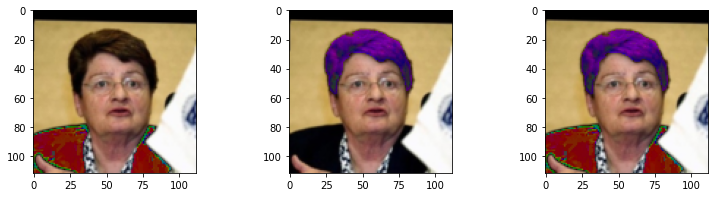

In [74]:
fig = plt.figure(figsize=(13,3))
axs = fig.subplots(1,3)
axs[0].imshow(red)
axs[1].imshow(purple)
axs[2].imshow(red_purple)
fig.show()

red_embd = system.model.encode(torch.from_numpy(red).permute(2,0,1).unsqueeze(0))
red_embd = red_embd / red_embd.norm()
print(f'red : {img_embd @ red_embd.T}')

purple_embd = system.model.encode(torch.from_numpy(purple).permute(2,0,1).unsqueeze(0))
purple_embd = purple_embd / purple_embd.norm()
print(f'purple : {img_embd @ purple_embd.T}')

red_purple_embd = system.model.encode(torch.from_numpy(red_purple).permute(2,0,1).unsqueeze(0))
red_purple_embd = red_purple_embd / red_purple_embd.norm()
print(f'red purple : {img_embd @ red_purple_embd.T}')

In [14]:
print(img.shape)
img_embd = system.model.encode(img.unsqueeze(0))
img_embd = img_embd / img_embd.norm()
view = img + total_delta.expand(3,-1,-1)
view_embd = system.model.encode(view.unsqueeze(0))
view_embd = view_embd / view_embd.norm()
print(img_embd @ view_embd.T)

view2 = img + delta
view2_embd = system.model.encode(view2.unsqueeze(0))
view2_embd = view2_embd / view2_embd.norm()
print(img_embd @ view2_embd.T)


torch.Size([3, 112, 112])
tensor([[0.8232]], grad_fn=<MmBackward>)
tensor([[-0.1218]], grad_fn=<MmBackward>)


In [15]:
_,img3,_ = system.train_dataset[30]

normalized_view, view3 = system.view(img3.unsqueeze(0),True)
view3_embd = system.model.encode(view3)
view3_embd = view3_embd / view3_embd.norm()
print(img_embd @ view3_embd.T)


tensor([[-0.0577]], grad_fn=<MmBackward>)


### magnitude of delta vs sim similarity

In [16]:
similarities = []
similarities2 = []
similarities3 = []
similarities4 = []
x = np.linspace(0,1,1000)
normalized_view, view = system.view(img.unsqueeze(0),True)
delta = view[0] - img

img_embd = system.model.encode(img.unsqueeze(0))
img_embd = img_embd / img_embd.norm()

delta2 = torch.rand_like(delta)
delta2 = delta2 * 0.05 / delta2.abs().mean()

delta3 = torch.ones_like(delta)
delta3 = delta3 * 0.05 / delta3.abs().mean()

delta4 = torch.ones_like(delta)
delta4 = delta4 * -0.05 / delta4.abs().mean()

def scale_delta_and_calc_sim(img,delta,b,system):
    view_temp = (img + b/0.05 * delta).clamp(0,1)
    view_temp_embd = system.model.encode(view_temp.unsqueeze(0))
    view_temp_embd = view_temp_embd / view_temp_embd.norm()
    return (img_embd @ view_temp_embd.T).detach().numpy().flatten()

for b in x:
    similarities.append(scale_delta_and_calc_sim(img,delta,b,system))
    similarities2.append(scale_delta_and_calc_sim(img,delta2,b,system))
    similarities3.append(scale_delta_and_calc_sim(img,delta3,b,system))
    similarities4.append(scale_delta_and_calc_sim(img,delta4,b,system))

    

# plt.title("similarity vs budget")
# plt.plot(x,similarities,label='vm')
# plt.plot(x,similarities2,label='rand')
# plt.plot(x,similarities3,label='positive')
# plt.plot(x,similarities4,label='negative')
# plt.ylabel("similarity")
# plt.xlabel("budget magnitude")
# plt.legend()
# plt.show()

# from bokeh.plotting import figure,show
# from bokeh.io import output_notebook
# output_notebook()
f = figure(title="similarity vs budget", width=600, height=350)
f.line(x,similarities,legend_label='vm',line_color="blue")
f.line(x,similarities2,legend_label='rand',line_color="orange")
f.line(x,similarities3,legend_label='positive',line_color="green")
f.line(x,similarities4,legend_label='negative',line_color="red")
# f.ylabel("similarity")
# f.xlabel("budget magnitude")
# f.legend()
show(f)


In [12]:
# from bokeh.plotting import figure,show
# from bokeh.io import output_notebook
# output_notebook()
f = figure(title="similarity vs budget", width=600, height=350)
f.line(x,similarities,legend_label='vm',line_color="blue")
f.line(x,similarities2,legend_label='rand',line_color="orange")
f.line(x,similarities3,legend_label='positive',line_color="green")
f.line(x,similarities4,legend_label='negative',line_color="red")
# f.ylabel("similarity")
# f.xlabel("budget magnitude")
# f.legend()
show(f)

In [6]:
# import sys
# sys.path.append("/disk2/ofirb/dabs/deepDPM/DeepDPM/") # go to parent dir
from dabs.deepDPM.DeepDPM.src.clustering_models.clusternet_modules.clusternetasmodel import ClusterNetModel